# Experiment on Different Time-series Similarity Measures 1

### Loading

In [34]:
# load image and libraries
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from itertools import groupby
from scipy import signal
from sklearn import preprocessing
import pandas as pd
import time

plt.rcParams['figure.figsize'] = [10, 5]
plt.rcParams['figure.dpi'] = 150 # 200 e.g. is really fine, but slower

root_path = './processed_datasets/'
datasets = ['has', 'sp', 'fp', 'rb', 'sd', 'sr', 'hasb', 'ihas']

# load ground truth
ori_data_X = []
ori_data_y = []
sketch_X = []
for dataset in datasets:
    file_name = root_path + 'original_' + dataset  
    ori_data_X.append(np.load(file_name + '_X' + '.npy'))
    ori_data_y.append(np.load(file_name + '_y' + '.npy'))
    file_name = root_path + 'sketch_' + dataset + '.npy'
    sketch_X.append(np.load(file_name, allow_pickle=True)[:100])
print(f"number of loaded samples per class: {[len(x) for x in sketch_X]}")
print(f"Original data: {len(ori_data_X)} datasets")
print(f"Sketch data: {len(sketch_X)} datasets")


number of loaded samples per class: [100, 100, 100, 100, 100, 100, 100, 100]
Original data: 8 datasets
Sketch data: 8 datasets


### Sliding Window

In [35]:
def sliding_window(ori_series, clip_series, measure):
    """
    Compute the similarities of the original and the clipped series using sliding window
    input: original time series, clipped series, similarity measure function
    output: similarity_distribution, matching result, i.e., starting and ending points
    """
    ori_len = ori_series.shape[0]
    clip_len = clip_series.shape[0]
    if ori_len < clip_len:
        return None

    # compute the similarity between the original and the clipped series
    dist = []
    # compute the similarity between the original and the clipped series using sliding window
    for i in range(ori_len - clip_len + 1):
        dist.append(measure(ori_series[i:i+clip_len], clip_series))
    # find the maximum similarity and the corresponding starting and ending points
    min_idx = np.argmin(dist)
    return dist, [min_idx, min_idx + clip_len - 1]


In [36]:
def pointwise_exp(ori_data_X, ori_data_y, sketch_X, measure):
    results = []
    for i, dataset in enumerate(datasets):
        original = ori_data_X[i]
        label = ori_data_y[i]
        dummy_record = []
        for sample in sketch_X[i]:
            clip =  signal.resample(sample, label[1]-label[0]+1)
            sim_dist, pred_loc = sliding_window(original, clip, measure)
            dummy_record.append([sim_dist, pred_loc])
        results.append(dummy_record)
    return results

### Define Metrics

#### Euclidean Distance

In [37]:
def euclidean_distance(x,y):
    t = preprocessing.Normalizer()
    x = np.expand_dims(x, axis=0)
    y = np.expand_dims(y, axis=0)
    return np.linalg.norm(t.transform(x) - t.transform(y))

#### Mahattan Distance

In [38]:
def mahattan_distance(x,y):
    t = preprocessing.Normalizer()
    x = np.expand_dims(x, axis=0)
    y = np.expand_dims(y, axis=0)
    return np.abs(t.transform(x) - t.transform(y)).sum()

#### Dynamic Time Warping (DTW)
Based on tslearn: https://github.com/tslearn-team/tslearn/

In [39]:
from tslearn.metrics import dtw
def dtw_distance(x,y):
    t = preprocessing.Normalizer()
    x = np.expand_dims(x, axis=0)
    y = np.expand_dims(y, axis=0)
    return dtw(t.transform(x)[0], t.transform(y)[0])

#### Canonical Time Warping (CTW)
Based on tslearn: https://github.com/tslearn-team/tslearn/

Canonical Time Warping is a method to align time series under rigid registration of the feature space. It should not be confused with Dynamic Time Warping (DTW), though CTW uses DTW.

In [40]:
from tslearn.metrics import ctw
def ctw_distance(x,y):
    t = preprocessing.Normalizer()
    x = np.expand_dims(x, axis=0)
    y = np.expand_dims(y, axis=0)
    return ctw(t.transform(x)[0], t.transform(y)[0])

#### Longest Common Subsequence (LCSS)
Based on tslearn: https://github.com/tslearn-team/tslearn/

LCSS is computed by matching indexes that are met up until the eps threshold, so it leaves some points unmatched and focuses on the similar parts of two sequences. The matching can occur even if the time indexes are different, regulated through the delta parameter that defines how far it can go. To retrieve a meaningful similarity value from the length of the longest common subsequence, the percentage of that value regarding the length of the shortest time series is returned.

According to this definition, the values returned by LCSS range from 0 to 1, the highest value taken when two time series fully match, and vice-versa. Therefore, we deine the distance to be 1-similarity.

In [41]:
from tslearn.metrics import lcss
def lcss_distance(x,y):
    t = preprocessing.Normalizer()
    x = np.expand_dims(x, axis=0)
    y = np.expand_dims(y, axis=0)
    return 1 - lcss(t.transform(x)[0], t.transform(y)[0])

#### Soft-DTW
Based on tslearn: https://github.com/tslearn-team/tslearn/

Improves DTW by using soft-min operator.

In [42]:
from tslearn.metrics import soft_dtw
def sdtw_distance(x,y):
    t = preprocessing.Normalizer()
    x = np.expand_dims(x, axis=0)
    y = np.expand_dims(y, axis=0)
    return soft_dtw(t.transform(x)[0], t.transform(y)[0])

#### Global Alignment kernel (GAK)
Based on tslearn: https://github.com/tslearn-team/tslearn/

See also: M. Cuturi, “Fast global alignment kernels,” ICML 2011.

In [43]:
from tslearn.metrics import gak
def gak_distance(x,y):
    t = preprocessing.Normalizer()
    x = np.expand_dims(x, axis=0)
    y = np.expand_dims(y, axis=0)
    return 1 - gak(t.transform(x)[0], t.transform(y)[0])

### MASS Algorithm (if having time to examine..)
https://github.com/matrix-profile-foundation/mass-ts

### Qetch Algorithm

In [44]:
#Qetch Algorithm -- inclomplete --

def width(series):
    # Should return width of series


    return 
    
def height(series):
    # Should return width of series

    return 

def get_LDE(sketch_split,Candidate_split,Gx,Gy):
    Rx = width(Candidate_split)/(Gx * width(sketch_split))    
    Ry = height(Candidate_split)/(Gy * height(sketch_split))  
    return (np.log(Rx)**2)+(np.log(Ry)**2)

def get_ShapeError(Sketch,Candidate,Gx,Gy,k):


    return 
def calculatDistance(Sketch, Candidate,k):
    # Calculating Global non uniform Scaling facctors
    Gx = width(Candidate)/width(Sketch)
    Gy = height(Candidate)/height(Sketch)
    # Calculating Shape error
    SE = get_ShapeError(Sketch,Candidate,Gx,Gy)
    sketch_split = np.split(Sketch,k)
    Candidate_split = np.split(Candidate,k)
    # Calculating Local distortion errors
    LDE = 0
    for i in range(k):
        LDE += get_LDE(Sketch[i],Candidate[i],Gx,Gy,k)

    # Calculating total error
    Dist = LDE + SE
    return Dist


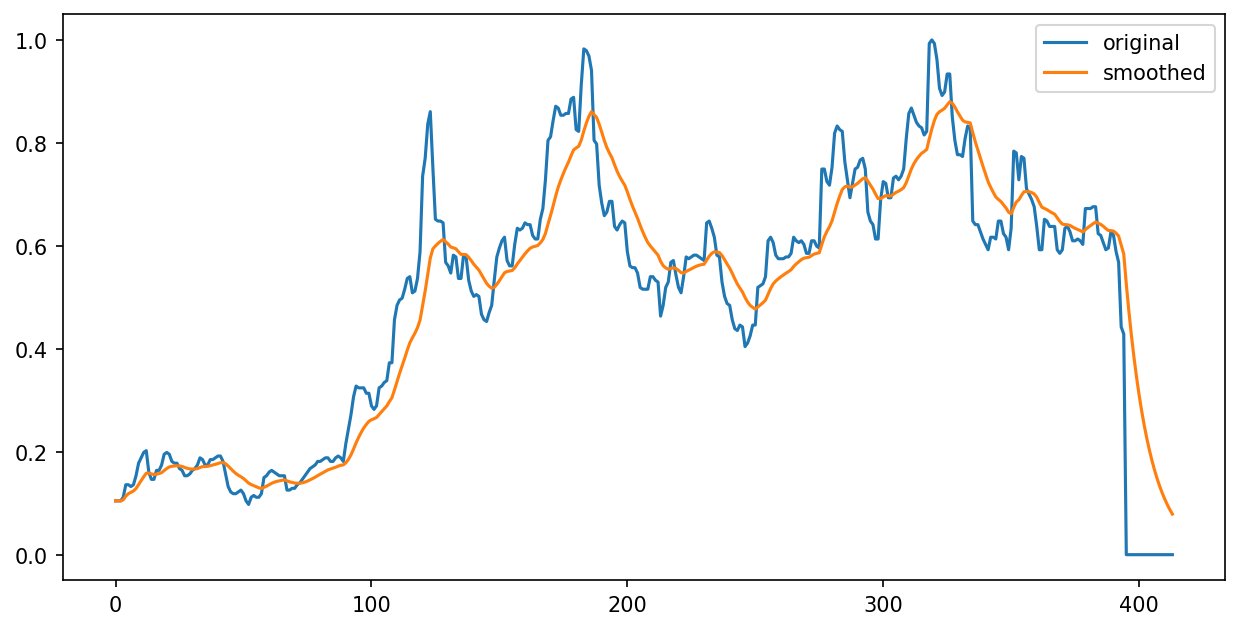

In [45]:
# Test the exponential moving average (emw)
# https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.ewm.html
alpha  = 0.1
test_X = pd.DataFrame(ori_data_X[0])
smoothed_X = test_X.ewm(alpha=alpha)
smoothed_X = smoothed_X.mean()
plt.figure()
plt.plot(test_X)
plt.plot(smoothed_X)
plt.legend(['original', 'smoothed'])
plt.show()

### Experiment 1: Matching Performance

#### Analysis

In [46]:
def analyze_results(results, plot = True, ori_data_X=ori_data_X, ori_data_Y=ori_data_y, datasets=datasets):
    d = {'Dataset':[], 'Number of samples':[], 'Average distance':[], 'Average location error (%)':[]}
    for i in range(len(results)):
        d['Dataset'].append(datasets[i])
        d['Number of samples'].append(len(results[i]))
        d['Average distance'].append(np.mean([np.max(x[0]) for x in results[i]]))
        d['Average location error (%)'].append(np.mean([np.abs(x[1][0] - ori_data_y[i][0])/ ori_data_X[i].shape[0]*100 for x in results[i]]))
        dummy = {"Dataset": datasets[i], "Number of samples": len(results[i]), "Average distance": np.mean([np.max(x[0]) for x in results[i]]),
                 "Average location error (%)": np.mean([np.abs(x[1][0] - ori_data_y[i][0])/ ori_data_X[i].shape[0]*100 for x in results[i]])}
    df = pd.DataFrame(d)
    display(df)
    display(df.iloc[:,[2,3]].describe())
    print(f'Average location error w.r.t. total length: {np.mean([np.mean([np.abs(x[1][0] - ori_data_y[i][0])/ ori_data_X[i].shape[0]*100 for x in results[i]]) for i in range(len(results))])}%')
    if plot:
        plt.figure()
        for i in range(len(results)):
            ax = plt.subplot(3,3,i+1)
            plt.tight_layout()
            plt.title(f"Dataset: {datasets[i]}")
            plt.xlabel("Time")
            plt.ylabel("Distance")
            plt.plot(results[i][0][0])
            plt.plot(results[i][0][1], [0.5, 0.5], marker='*', ls='none')
            plt.plot(ori_data_y[i], [0.5, 0.5], marker='o', color='r', ls='none')
        plt.legend(['Distance', 'Predicted', 'Ground Truth'],bbox_to_anchor=(2,0), loc='lower right')
        plt.show()
    return df

#### Get results

In [47]:
measures = [euclidean_distance, mahattan_distance, dtw_distance, lcss_distance, sdtw_distance, gak_distance]
d = {'Method':[], 'Average location error (%)':[], 'Running time (s)':[]}
for measure in measures:
    print(f"Measure: {measure.__name__}")
    d['Method'].append(measure.__name__)
    tic = time.time()
    results = pointwise_exp(ori_data_X, ori_data_y, sketch_X, measure)
    toc = time.time()
    print(f"Time elasped: {toc-tic} seconds")
    df = analyze_results(results, plot = False)
    d['Average location error (%)'].append(df.iloc[:,3].mean())
    d['Running time (s)'].append(toc-tic)
    print('--------------------------------------------------------')
df = pd.DataFrame(d)
display(df)

Measure: euclidean_distance
Time elasped: 16.145642042160034 seconds


,Dataset,Number of samples,Average distance,Average location error (%)
0,has,100,0.868820,7.251208
1,sp,100,0.894325,17.347826
2,fp,100,1.026507,12.874396
3,rb,100,1.139434,1.932367
4,sd,100,0.586013,3.045894
5,sr,100,1.239033,23.241546
6,hasb,100,0.669684,8.983092
7,ihas,100,0.752768,10.975904


,Average distance,Average location error (%)
count,8.000000,8.000000
mean,0.897073,10.706529
std,0.227572,7.137291
min,0.586013,1.932367
25%,0.731997,6.199879
50%,0.881572,9.979498
75%,1.054739,13.992754
max,1.239033,23.241546


Average location error w.r.t. total length: 10.706529014609162%
--------------------------------------------------------
Measure: mahattan_distance
Time elasped: 15.910403966903687 seconds


,Dataset,Number of samples,Average distance,Average location error (%)
0,has,100,8.285738,6.318841
1,sp,100,7.650034,16.613527
2,fp,100,8.144883,13.128019
3,rb,100,11.467559,1.734300
4,sd,100,3.066791,5.893720
5,sr,100,6.744708,18.533816
6,hasb,100,4.639287,9.557971
7,ihas,100,5.913132,10.867470


,Average distance,Average location error (%)
count,8.000000,8.000000
mean,6.989017,10.330958
std,2.553264,5.671422
min,3.066791,1.734300
25%,5.594671,6.212560
50%,7.197371,10.212720
75%,8.180097,13.999396
max,11.467559,18.533816


Average location error w.r.t. total length: 10.330957889529131%
--------------------------------------------------------
Measure: dtw_distance
Time elasped: 35.47163009643555 seconds


,Dataset,Number of samples,Average distance,Average location error (%)
0,has,100,0.678415,7.176329
1,sp,100,0.621693,12.927536
2,fp,100,0.707616,11.314010
3,rb,100,0.858138,1.553140
4,sd,100,0.442453,2.927536
5,sr,100,1.058595,16.120773
6,hasb,100,0.565764,19.599034
7,ihas,100,0.593285,2.886747


,Average distance,Average location error (%)
count,8.000000,8.000000
mean,0.690745,9.313138
std,0.190977,6.719575
min,0.442453,1.553140
25%,0.586405,2.917339
50%,0.650054,9.245169
75%,0.745247,13.725845
max,1.058595,19.599034


Average location error w.r.t. total length: 9.313138059484315%
--------------------------------------------------------
Measure: lcss_distance
Time elasped: 24.931681156158447 seconds


,Dataset,Number of samples,Average distance,Average location error (%)
0,has,100,0.0,25.845411
1,sp,100,0.0,59.661836
2,fp,100,0.0,31.642512
3,rb,100,0.0,28.502415
4,sd,100,0.0,39.130435
5,sr,100,0.0,41.062802
6,hasb,100,0.0,19.323671
7,ihas,100,0.0,40.963855


,Average distance,Average location error (%)
count,8.0,8.000000
mean,0.0,35.766617
std,0.0,12.397784
min,0.0,19.323671
25%,0.0,27.838164
50%,0.0,35.386473
75%,0.0,40.988592
max,0.0,59.661836


Average location error w.r.t. total length: 35.76661719341133%
--------------------------------------------------------
Measure: sdtw_distance
Time elasped: 136.33014607429504 seconds


,Dataset,Number of samples,Average distance,Average location error (%)
0,has,100,-235.436672,6.717391
1,sp,100,-193.261453,19.695652
2,fp,100,-168.186537,14.806763
3,rb,100,-220.459361,1.840580
4,sd,100,-83.364130,22.248792
5,sr,100,-100.714793,28.181159
6,hasb,100,-111.192918,8.980676
7,ihas,100,-144.356467,21.303614


,Average distance,Average location error (%)
count,8.000000,8.000000
mean,-157.121541,15.471829
std,56.653999,8.978810
min,-235.436672,1.840580
25%,-200.060930,8.414855
50%,-156.271502,17.251208
75%,-108.573387,21.539909
max,-83.364130,28.181159


Average location error w.r.t. total length: 15.47182861882312%
--------------------------------------------------------
Measure: gak_distance
Time elasped: 135.15723490715027 seconds


,Dataset,Number of samples,Average distance,Average location error (%)
0,has,100,0.675719,6.613527
1,sp,100,0.579123,14.695652
2,fp,100,0.721193,11.304348
3,rb,100,0.873772,1.760870
4,sd,100,0.302000,4.038647
5,sr,100,0.823351,19.929952
6,hasb,100,0.439828,8.442029
7,ihas,100,0.548762,9.903614


,Average distance,Average location error (%)
count,8.000000,8.000000
mean,0.620468,9.586080
std,0.192512,5.834742
min,0.302000,1.760870
25%,0.521529,5.969807
50%,0.627421,9.172822
75%,0.746732,12.152174
max,0.873772,19.929952


Average location error w.r.t. total length: 9.586079826552588%
--------------------------------------------------------


,Method,Average location error (%),Running time (s)
0,euclidean_distance,10.706529,16.145642
1,mahattan_distance,10.330958,15.910404
2,dtw_distance,9.313138,35.471630
3,lcss_distance,35.766617,24.931681
4,sdtw_distance,15.471829,136.330146
5,gak_distance,9.586080,135.157235
